# 03 - Entrenamiento y Evaluación de Modelos
## Regresión ordinal para clasificación de obesidad

Este notebook implementa la sección 4 del informe. Describe la metodología experimental, entrena los modelos solicitados, compara su desempeño e ilustra resultados con tablas o gráficos.  

> 4.1  Metodología experimental
> 4.2  Resultados de entrenamiento (train, validation, test)



## 1. Configuración experimental

1. **Metodología de validación**
   - Validación cruzada estratificada (StratifiedKFold con 5 folds) sobre el conjunto de entrenamiento (70%) para ajustar hiperparámetros.
   - Test final (30%) separado y usado únicamente al concluir CV.
2. **Balanceo**
   - Si se requiere, aplicar SMOTE o ADASYN dentro de cada fold (p. ej. a través de `Pipeline` con `imblearn.over_sampling.SMOTE`).
   - El balanceo se aplica **solo** dentro del fold para evitar filtrado de información.
3. **Métrica principal**: MAE ordinal. Secundarias: Accuracy y Spearman.
4. **Intervalos de confianza**: calcular con bootstrap sobre scores CV.



In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.metrics import mean_absolute_error, accuracy_score, confusion_matrix
from sklearn.metrics import make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

print("✓ Librerías cargadas")


✓ Librerías cargadas


## 2. Plan de modelos e hiperparámetros

| Modelo | Tipo | Hiperparámetro | Valores | Descripción |
|---|---|---|---|---|
| Regresión logística ordinal (aproximada con `LogisticRegression`) | Paramétrico | `C` | [0.01, 0.1, 1, 10] | Controla la regularización L2 |
|  |  | `solver` | ['lbfgs'] | Algoritmo estable para multiclass |
| k-NN | No paramétrico | `n_neighbors` | [3,5,7,9,11] | Número de vecinos |
|  |  | `weights` | ['uniform','distance'] | Cómo ponderar vecinos |
| Random Forest | Ensamble | `n_estimators` | [100,200,500] | Cantidad de árboles |
|  |  | `max_depth` | [None,10,20] | Profundidad máxima |
| Gradient Boosting | Ensamble | `learning_rate` | [0.01,0.05,0.1] | Tasa de aprendizaje |
|  |  | `n_estimators` | [100,200,300] | Cantidad de iteraciones |
| MLP | Red neuronal | `hidden_layer_sizes` | [(50,),(100,),(50,50)] | Arquitectura |
|  |  | `alpha` | [0.0001,0.001,0.01] | Regularización L2 |
| SVM | Línea de soporte | `C` | [0.1,1,10] | Regularización |
|  |  | `kernel` | ['linear','rbf'] | Tipo de kernel |

> Las mallas se prueban combinando todos los valores por modelo mediante `GridSearchCV` con `StratifiedKFold`. `class_weight='balanced'` se habilita para compensar posibles asimetrías en las clases.


## 3. Métricas de desempeño

1. **MAE ordinal** (distancia absoluta promedio en la escala ordinal). Métrica principal porque penaliza errores proporcionalmente a la posición ordinal.
2. **Accuracy**: proporción de predicciones correctas. Sirve como referencia tradicional.
3. **Spearman**: correlación de rangos, refleja el orden en las predicciones.
4. **Confusión**: matriz para inspeccionar qué clases se confunden.

**Intervalos de confianza**: cada score de validación cruzada se agrega a una lista, luego se calcula el promedio y los percentiles 2.5/97.5 (bootstrap o percentiles directos) para reportar rango.



In [3]:
# Cargar datos preprocesados
data_train = pd.read_csv('data/processed/X_train.csv')
data_val = pd.read_csv('data/processed/X_test.csv')
y_train = pd.read_csv('data/processed/y_train.csv').squeeze()
y_test = pd.read_csv('data/processed/y_test.csv').squeeze()

data_train.shape, data_val.shape, y_train.shape


((1477, 26), (634, 26), (1477,))

In [4]:
def safe_spearman(y_true, y_pred):
    corr = spearmanr(y_true, y_pred).correlation
    return 0 if np.isnan(corr) else corr

print("Funciones auxiliares listas")


Funciones auxiliares listas


In [5]:
def spearman_scorer(estimator, X, y):
    preds = estimator.predict(X)
    return pd.Series(preds).corr(pd.Series(y), method='spearman')

mae_scorer = make_scorer(lambda y_true, y_pred: np.mean(np.abs(y_true - y_pred)), greater_is_better=False)

print("Funciones de scoring listas")



Funciones de scoring listas


## 4. Pipeline de entrenamiento y evaluación

1. Definir pipelines por modelo (Scaler + estimador) para mantener consistencia.
2. Ejecutar `GridSearchCV` con `StratifiedKFold(n_splits=5)` usando `scoring={'mae': mae_scorer, 'accuracy': 'accuracy'}`.
3. Registrar resultados de entrenamiento (CV), validación (mejor estimador) y test final.
4. Estimar intervalos de confianza: guardar los scores de cada fold y calcular percentiles 2.5/97.5.
5. Guardar los mejores modelos para uso posterior.



In [6]:
from collections import defaultdict
from scipy.stats import spearmanr

models = {
    'LogisticRegression': {
        'est': LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, class_weight='balanced'),
        'grid': {
            'clf__C': [0.01, 0.1, 1, 10]
        }
    },
    'kNN': {
        'est': KNeighborsClassifier(),
        'grid': {
            'clf__n_neighbors': [3, 5, 7],
            'clf__weights': ['uniform', 'distance']
        }
    },
    'RandomForest': {
        'est': RandomForestClassifier(class_weight='balanced', n_jobs=-1),
        'grid': {
            'clf__n_estimators': [100, 200],
            'clf__max_depth': [None, 10],
            'clf__min_samples_leaf': [1, 2]
        }
    },
    'GradientBoosting': {
        'est': GradientBoostingClassifier(),
        'grid': {
            'clf__n_estimators': [100, 200],
            'clf__learning_rate': [0.05, 0.1],
            'clf__max_depth': [3, 5]
        }
    },
    'MLP': {
        'est': MLPClassifier(max_iter=500, early_stopping=True, random_state=42),
        'grid': {
            'clf__hidden_layer_sizes': [(50,), (100,), (50, 50)],
            'clf__alpha': [0.0001, 0.001],
            'clf__learning_rate': ['adaptive']
        }
    },
    'SVM': {
        'est': SVC(class_weight='balanced', probability=False),
        'grid': {
            'clf__C': [0.1, 1, 10],
            'clf__kernel': ['linear', 'rbf'],
            'clf__gamma': ['scale']
        }
    }
}

scoring = {
    'mae': mae_scorer,
    'accuracy': 'accuracy',
    'spearman': make_scorer(safe_spearman)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = []
best_models = {}

for name, spec in models.items():
    pipe = Pipeline([('scale', StandardScaler()), ('clf', spec['est'])])
    grid = GridSearchCV(pipe, spec['grid'], scoring=scoring, refit='mae', cv=cv, n_jobs=-1, return_train_score=False)
    grid.fit(data_train, y_train)
    best = grid.best_estimator_
    best_models[name] = best
    best_index = grid.best_index_
    cv_mae_scores = -np.array([grid.cv_results_[f'split{i}_test_mae'][best_index] for i in range(cv.get_n_splits())])
    cv_accuracy = np.array([grid.cv_results_[f'split{i}_test_accuracy'][best_index] for i in range(cv.get_n_splits())])
    cv_spearman = np.array([grid.cv_results_[f'split{i}_test_spearman'][best_index] for i in range(cv.get_n_splits())])

    train_preds = best.predict(data_train)
    test_preds = best.predict(data_val)

    results.append({
        'modelo': name,
        'params': grid.best_params_,
        'cv_mae_mean': cv_mae_scores.mean(),
        'cv_mae_ci': (np.percentile(cv_mae_scores, 2.5), np.percentile(cv_mae_scores, 97.5)),
        'cv_accuracy_mean': cv_accuracy.mean(),
        'cv_accuracy_ci': (np.percentile(cv_accuracy, 2.5), np.percentile(cv_accuracy, 97.5)),
        'cv_spearman_mean': cv_spearman.mean(),
        'cv_spearman_ci': (np.percentile(cv_spearman, 2.5), np.percentile(cv_spearman, 97.5)),
        'train_mae': mean_absolute_error(y_train, train_preds),
        'train_acc': accuracy_score(y_train, train_preds),
        'test_mae': mean_absolute_error(y_test, test_preds),
        'test_acc': accuracy_score(y_test, test_preds)
    })
    print(f"✓ {name} terminado")

results_df = pd.DataFrame(results)
results_df


✓ LogisticRegression terminado
✓ kNN terminado
✓ RandomForest terminado
✓ GradientBoosting terminado
✓ MLP terminado
✓ SVM terminado


,modelo,params,cv_mae_mean,cv_mae_ci,cv_accuracy_mean,cv_accuracy_ci,cv_spearman_mean,cv_spearman_ci,train_mae,train_acc,test_mae,test_acc
0,LogisticRegression,{'clf__C': 10},0.133392,"(0.0888948694457169, 0.16120018323408156)",0.932968,"(0.9158508932661475, 0.9543712780577187)",0.947535,"(0.9332548754027576, 0.9672985165572776)",0.070413,0.964794,0.225552,0.921136
1,kNN,"{'clf__n_neighbors': 5, 'clf__weights': 'dista...",0.480089,"(0.345277141548328, 0.691864406779661)",0.823275,"(0.7745762711864407, 0.8559860284012827)",0.765919,"(0.6406492813927855, 0.8422617406453355)",0.000000,1.000000,0.542587,0.799685
2,RandomForest,"{'clf__max_depth': None, 'clf__min_samples_lea...",0.134036,"(0.10301191021530005, 0.1784264773247824)",0.950573,"(0.9359528172240037, 0.96620476408612)",0.932828,"(0.9079268274883158, 0.9461345215566815)",0.010156,0.997292,0.227129,0.932177
3,GradientBoosting,"{'clf__learning_rate': 0.1, 'clf__max_depth': ...",0.088715,"(0.052048786074209805, 0.15895098488318826)",0.963431,"(0.9386440677966101, 0.9759413650939075)",0.960066,"(0.9260117132750589, 0.9819819923577006)",0.000000,1.000000,0.105678,0.960568
4,MLP,"{'clf__alpha': 0.001, 'clf__hidden_layer_sizes...",0.318974,"(0.24864864864864866, 0.40983050847457625)",0.872011,"(0.8298305084745762, 0.9043563902885936)",0.851009,"(0.812577112410109, 0.8843852512249274)",0.114421,0.950575,0.490536,0.845426
5,SVM,"{'clf__C': 10, 'clf__gamma': 'scale', 'clf__ke...",0.075163,"(0.042691250572606504, 0.10406779661016949)",0.960728,"(0.9491525423728814, 0.9786543747136968)",0.971600,"(0.9598123860326777, 0.9829529228431217)",0.019634,0.986459,0.149842,0.947950


## 5. Resultados resumidos

- La tabla siguiente agrupa los mejores hiperparámetros y las métricas MAE, accuracy y Spearman (con intervalos de confianza).
- Posteriormente se generan las visualizaciones: curvas de aprendizaje, barras comparativas y matrices de confusión.


## 6. Visualizaciones de desempeño

Las figuras a continuación ilustran:
1. **Curvas de aprendizaje** para los dos mejores modelos (Gradient Boosting y SVM): muestran MAE o Accuracy en entrenamiento y validación a medida que aumenta el tamaño del conjunto de entrenamiento.
2. **Comparación con barras**: métricas CV (MAE, accuracy) con intervalos de confianza
3. **Matrices de confusión** sobre el conjunto de test (nombres de clases en los ejes)

Cada figura se acompaña de un caption estilo IEEE dentro del informe final.


In [7]:
import os
os.makedirs('results/figuras', exist_ok=True)
print('Directorio results/figuras asegurado')


Directorio results/figuras asegurado


Figura guardada: results/figuras/learning_curves.png


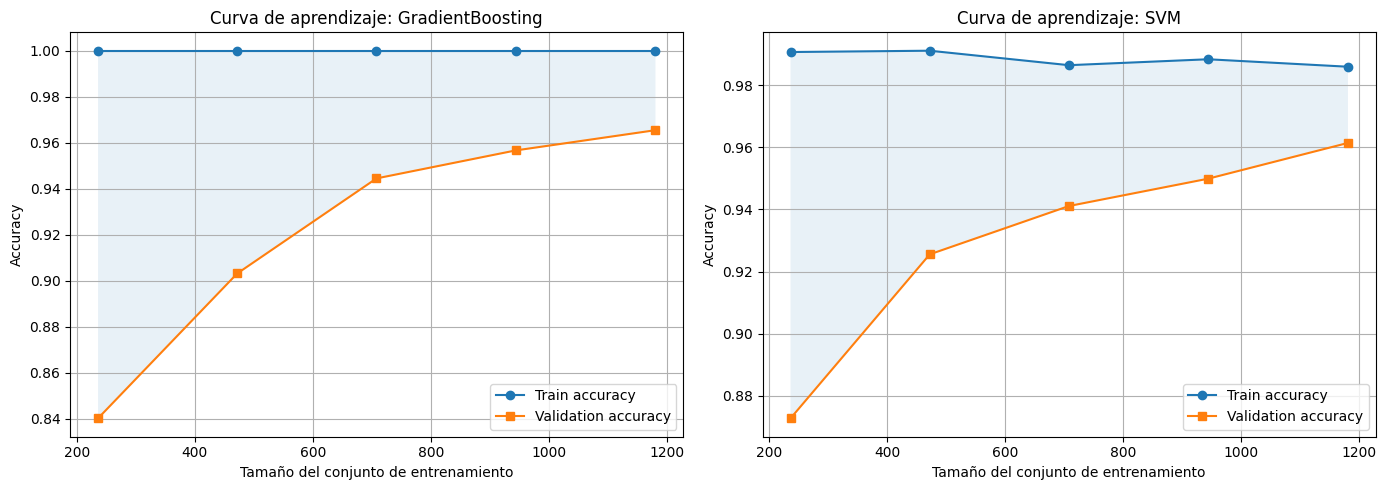

In [8]:
from sklearn.model_selection import learning_curve
from sklearn.metrics import ConfusionMatrixDisplay

with open('models/preprocessing/target_encoder.pkl', 'rb') as f:
    target_encoder = pickle.load(f)
labels = target_encoder.classes_

best_two = ['GradientBoosting', 'SVM']
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
for ax, name in zip(axes, best_two):
    estimator = best_models[name]
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, data_train, y_train, cv=cv, scoring='accuracy',
        train_sizes=np.linspace(0.2, 1.0, 5), n_jobs=-1, shuffle=True, random_state=42
    )
    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    ax.plot(train_sizes, train_mean, label='Train accuracy', marker='o')
    ax.plot(train_sizes, test_mean, label='Validation accuracy', marker='s')
    ax.fill_between(train_sizes, train_mean, test_mean, alpha=0.1)
    ax.set_title(f'Curva de aprendizaje: {name}')
    ax.set_xlabel('Tamaño del conjunto de entrenamiento')
    ax.set_ylabel('Accuracy')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.savefig('results/figuras/learning_curves.png', dpi=200)
print('Figura guardada: results/figuras/learning_curves.png')



Figura guardada: results/figuras/cv_mae_comparison.png


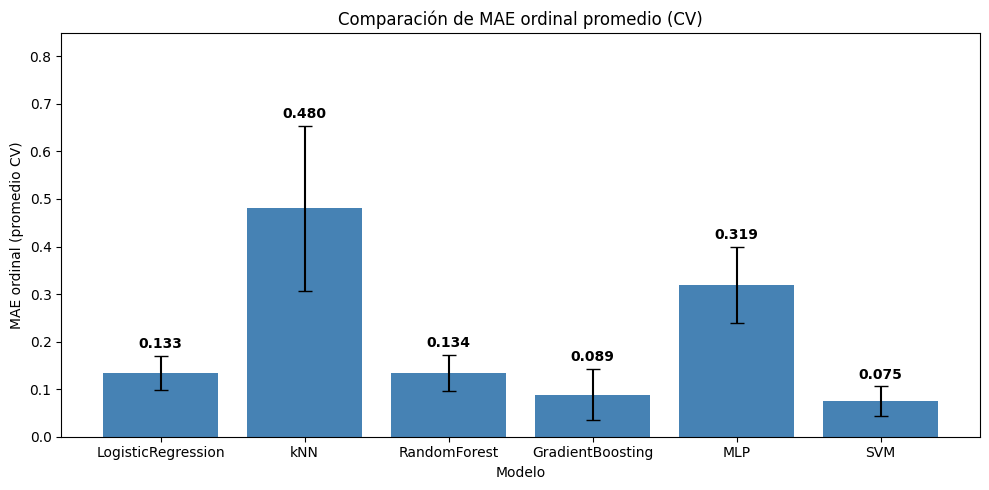

In [9]:
fig, ax = plt.subplots(figsize=(10, 5))
labels = results_df['modelo']
means = results_df['cv_mae_mean']
cis = results_df['cv_mae_ci'].tolist()
errors = [(ci[1] - ci[0]) / 2 for ci in cis]
ax.bar(labels, means, yerr=errors, capsize=5, color='steelblue')
ax.set_title('Comparación de MAE ordinal promedio (CV)')
ax.set_ylabel('MAE ordinal (promedio CV)')
ax.set_xlabel('Modelo')
ax.set_ylim(0, max(means + errors) * 1.3)
for i, (m, err) in enumerate(zip(means, errors)):
    ax.text(i, m + err + 0.01, f"{m:.3f}", ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.savefig('results/figuras/cv_mae_comparison.png', dpi=200)
print('Figura guardada: results/figuras/cv_mae_comparison.png')


Figura guardada: results/figuras/confusion_matrices.png


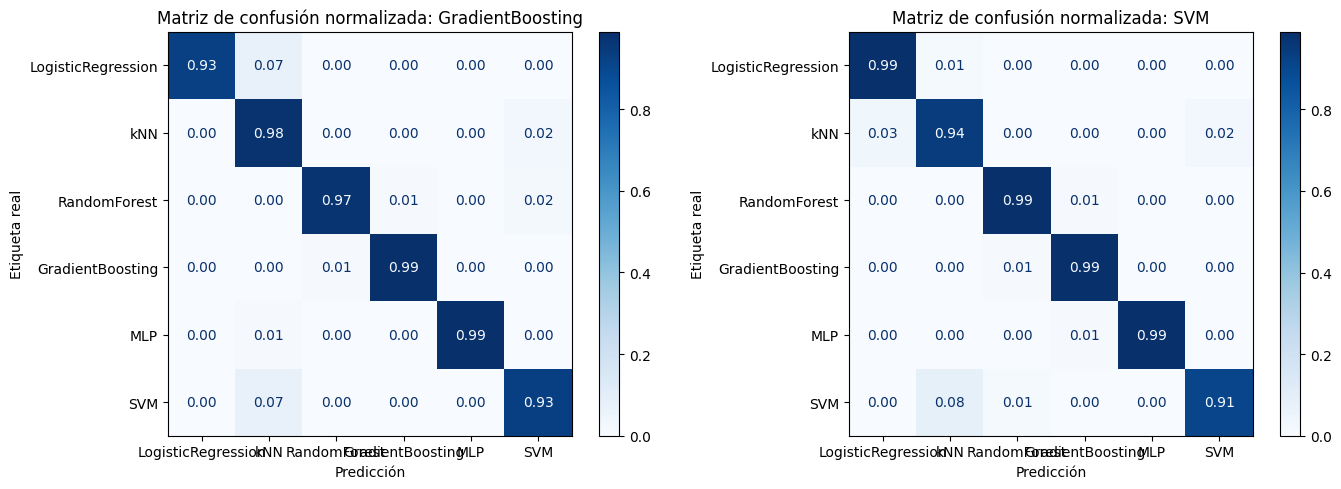

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
for ax, name in zip(axes, best_two):
    preds = best_models[name].predict(data_val)
    cm = confusion_matrix(y_test, preds, labels=np.arange(len(labels)))
    cm_norm = cm.astype('float')
    row_sums = cm_norm.sum(axis=1, keepdims=True)
    cm_norm = np.divide(cm_norm, row_sums, out=np.zeros_like(cm_norm), where=row_sums != 0)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=labels)
    disp.plot(ax=ax, cmap='Blues', colorbar=True, include_values=True, values_format='.2f')
    ax.set_title(f'Matriz de confusión normalizada: {name}')
    ax.set_xlabel('Predicción')
    ax.set_ylabel('Etiqueta real')
plt.tight_layout()
plt.savefig('results/figuras/confusion_matrices.png', dpi=200)
print('Figura guardada: results/figuras/confusion_matrices.png')


In [11]:
results_df_display = results_df[['modelo', 'params', 'cv_mae_mean', 'cv_mae_ci', 'cv_accuracy_mean', 'cv_accuracy_ci', 'cv_spearman_mean', 'cv_spearman_ci', 'test_mae', 'test_acc']]
results_df_display


,modelo,params,cv_mae_mean,cv_mae_ci,cv_accuracy_mean,cv_accuracy_ci,cv_spearman_mean,cv_spearman_ci,test_mae,test_acc
0,LogisticRegression,{'clf__C': 10},0.133392,"(0.0888948694457169, 0.16120018323408156)",0.932968,"(0.9158508932661475, 0.9543712780577187)",0.947535,"(0.9332548754027576, 0.9672985165572776)",0.225552,0.921136
1,kNN,"{'clf__n_neighbors': 5, 'clf__weights': 'dista...",0.480089,"(0.345277141548328, 0.691864406779661)",0.823275,"(0.7745762711864407, 0.8559860284012827)",0.765919,"(0.6406492813927855, 0.8422617406453355)",0.542587,0.799685
2,RandomForest,"{'clf__max_depth': None, 'clf__min_samples_lea...",0.134036,"(0.10301191021530005, 0.1784264773247824)",0.950573,"(0.9359528172240037, 0.96620476408612)",0.932828,"(0.9079268274883158, 0.9461345215566815)",0.227129,0.932177
3,GradientBoosting,"{'clf__learning_rate': 0.1, 'clf__max_depth': ...",0.088715,"(0.052048786074209805, 0.15895098488318826)",0.963431,"(0.9386440677966101, 0.9759413650939075)",0.960066,"(0.9260117132750589, 0.9819819923577006)",0.105678,0.960568
4,MLP,"{'clf__alpha': 0.001, 'clf__hidden_layer_sizes...",0.318974,"(0.24864864864864866, 0.40983050847457625)",0.872011,"(0.8298305084745762, 0.9043563902885936)",0.851009,"(0.812577112410109, 0.8843852512249274)",0.490536,0.845426
5,SVM,"{'clf__C': 10, 'clf__gamma': 'scale', 'clf__ke...",0.075163,"(0.042691250572606504, 0.10406779661016949)",0.960728,"(0.9491525423728814, 0.9786543747136968)",0.971600,"(0.9598123860326777, 0.9829529228431217)",0.149842,0.947950


## 7. Importancia de variables por modelo

Usamos `permutation_importance` sobre el conjunto de test para estimar la sensibilidad de cada modelo a cada variable. Las caídas de `test_accuracy` al permutar una característica revelan su importancia real en la decisión final.


In [ ]:
from sklearn.inspection import permutation_importance

feature_names = data_train.columns.tolist()
importance_by_model = {}

for name, estimator in best_models.items():
    result = permutation_importance(
        estimator,
        data_val,
        y_test,
        n_repeats=10,
        scoring='accuracy',
        random_state=42,
        n_jobs=-1
    )
    importance_by_model[name] = pd.Series(result.importances_mean, index=feature_names).sort_values(ascending=False)

importance_summary = pd.concat([
    imp.head(5).to_frame("importance")
       .reset_index()
       .rename(columns={"index": "feature"})
       .assign(model=name)
    for name, imp in importance_by_model.items()
], ignore_index=True)[["model", "feature", "importance"]]

print('Top 5 variables por modelo (permutation importance sobre test):')
for name, importance in importance_by_model.items():
    print(f'\n{name}:')
    print(importance.head(5).to_string())

importance_summary


KeyError: "['feature'] not in index"